In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [24]:
# Charger le dataset

df = pd.read_csv('températures_globales.csv',sep=',')
df.head()

,Unnamed: 0,Year,Month,Anomaly-Gl,Uncertainty-Gl
0,0,1753,1,-1.264,3.651
1,1,1753,2,-1.985,4.124
2,2,1753,3,0.279,3.657
3,3,1753,4,-1.289,2.167
4,4,1753,5,-0.436,2.144


Préparation du jeu de données , nettoyage, mise en forme dataset 

In [25]:
df.tail()                                                           # 
df.isna().sum()
df.duplicated().sum()

df = df.drop(columns='Unnamed: 0')

In [26]:
df['Périodes'] = pd.to_datetime(df['Year'].astype(str)+'-'+ df['Month'].astype(str))            # periode annee/mois/jour
df = df.drop(columns=['Year','Month'])                                                          # on supprime colonnes annees et mois
df =df.reindex(columns=['Périodes','Anomaly-Gl','Uncertainty-Gl'])                              # pour confort visuel 

df = df.rename({'Anomaly-Gl':'Anomalies de T.°','Uncertainty-Gl':'Incertitude T.° anomalie'},axis=1)

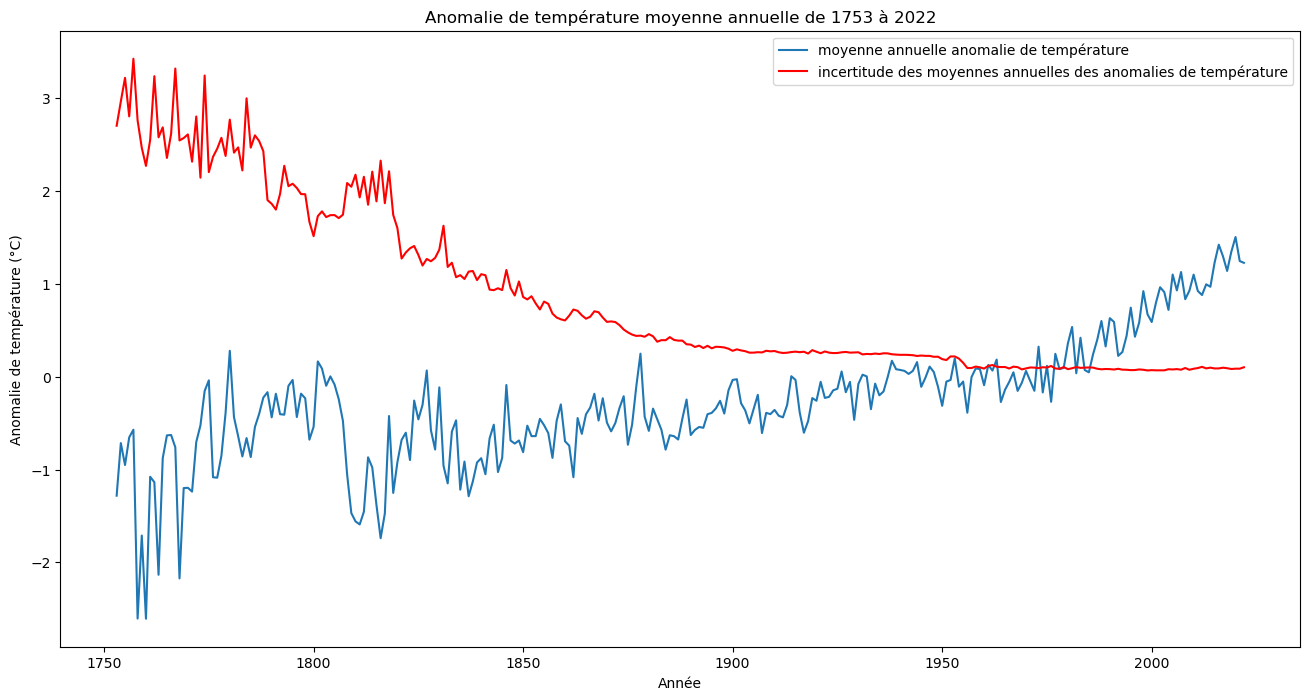

In [27]:
# Regrouper les données par année et calculer la moyenne de l'anomalie de température
df_annee_at = df.groupby(df['Périodes'].dt.year)['Anomalies de T.°'].mean()
df_annee_inc = df.groupby(df['Périodes'].dt.year)['Incertitude T.° anomalie'].mean()

# Tracer le graphique avec plt.plot()
plt.figure(figsize=(16,8))
plt.plot(df_annee_at.index, df_annee_at.values, label='moyenne annuelle anomalie de température')
plt.plot(df_annee_inc.index, df_annee_inc.values,color='red',label='incertitude des moyennes annuelles des anomalies de température')

# Ajouter les étiquettes d'axe et le titre
plt.xlabel('Année')
plt.ylabel('Anomalie de température (°C)')
plt.title('Anomalie de température moyenne annuelle de 1753 à 2022')
plt.legend();

In [28]:
df = df.loc [ df['Périodes']>= '1960-01-01']       # on gardera les anomalies de t.° après 1960 où les incertitudes d'anomalies sont quasi nulles 

In [29]:
# Séparer les données d'entraînement et de test en fonction de la date cutoff : 

cutoff_date = pd.to_datetime("2010-01-01")


train_df = df.loc[df["Périodes"] < cutoff_date]
test_df = df[df["Périodes"] >= cutoff_date]

In [30]:
# Définir les variables d'entrée (années) et de sortie (anomalies de température) pour l'entraînement

X_train = train_df["Périodes"].values.reshape(-1, 1)
y_train = train_df["Anomalies de T.°"].values.reshape(-1, 1)

# Définir les variables d'entrée (années) et de sortie (anomalies de température) pour le test

X_test = test_df["Périodes"].values.reshape(-1, 1)
y_test = test_df["Anomalies de T.°"].values.reshape(-1, 1)

In [31]:
# Créer un pipeline de prétraitement qui inclut la transformation polynomiale

polynomial_features = PolynomialFeatures()
linear_regression = LinearRegression()
pipeline = Pipeline([("polynomial_features", polynomial_features), ("linear_regression", linear_regression)])

# Définir les hyperparamètres à tester
parameters = {"polynomial_features__degree": [ i for i in range(1,15)]}

# Rechercher les meilleurs hyperparamètres à l'aide de GridSearchCV   , à noter on utilise une TimeSeriesSplit pour tenir compte de la chronologie des données
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(pipeline, parameters, cv=tscv, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('polynomial_features',
                                        PolynomialFeatures()),
                                       ('linear_regression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'polynomial_features__degree': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 11, 12, 13,
                                                         14]})

In [32]:
# Afficher les meilleurs hyperparamètres sur le dataset d'entraînement

print("Meilleurs hyperparamètres : ", grid_search.best_params_)


Meilleurs hyperparamètres :  {'polynomial_features__degree': 1}


In [33]:
# Extraire le meilleur modèle du pipeline

best_model = grid_search.best_estimator_

In [34]:
print(best_model)

Pipeline(steps=[('polynomial_features', PolynomialFeatures(degree=1)),
                ('linear_regression', LinearRegression())])


In [35]:
# Faire des prédictions sur les données d'entraînement et d'évaluation avec le modele polynomiale d ordre 1

train_predictions = best_model.predict(X_train)
test_predictions = best_model.predict(X_test)

In [36]:
# Calculer les métriques de performance pour le modèle d'entraînement

train_mae = mean_absolute_error(y_train, train_predictions)
train_mse = mean_squared_error(y_train, train_predictions)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, train_predictions)

In [37]:
# Calculer les métriques de performance pour le modèle d'évaluation

test_mae = mean_absolute_error(y_test, test_predictions)
test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, test_predictions)

In [38]:
print("Performances du modèle sur l'ensemble d'entraînement : ")
print(f"MAE : {train_mae}")
print(f"MSE : {train_mse}")
print(f"RMSE : {train_rmse}")
print(f"R² : {train_r2}")

print("\nPerformances du modèle sur l'ensemble de test : ")
print(f"MAE : {test_mae}")
print(f"MSE : {test_mse}")
print(f"RMSE : {test_rmse}")
print(f"R² : {train_r2}")

Performances du modèle sur l'ensemble d'entraînement : 
MAE : 0.26096916098541445
MSE : 0.11189778207153495
RMSE : 0.33451125851237795
R² : 0.5014505205687894

Performances du modèle sur l'ensemble de test : 
MAE : 0.2394088342016738
MSE : 0.10693830147168185
RMSE : 0.3270142221244847
R² : 0.5014505205687894


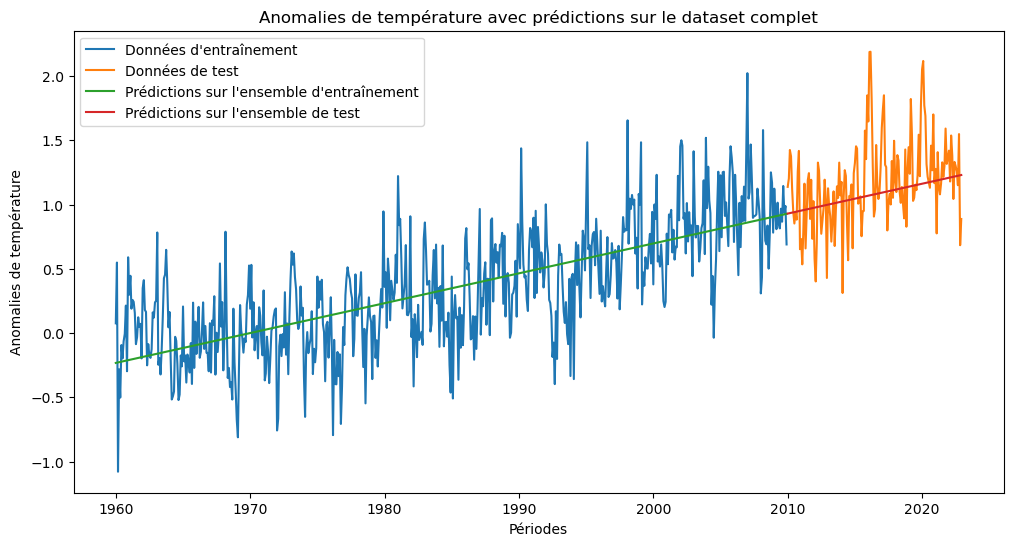

In [39]:
import matplotlib.pyplot as plt

# Prédire les anomalies de température pour l'ensemble d'entraînement et l'ensemble de test

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Visualiser les prédictions par rapport aux données réelles
plt.figure(figsize=(12, 6))
plt.plot(train_df["Périodes"], y_train, label="Données d'entraînement")
plt.plot(test_df["Périodes"], y_test, label="Données de test")
plt.plot(train_df["Périodes"], y_train_pred, label="Prédictions sur l'ensemble d'entraînement")
plt.plot(test_df["Périodes"], y_test_pred, label="Prédictions sur l'ensemble de test")
plt.legend()
plt.xlabel("Périodes")
plt.ylabel("Anomalies de température")
plt.title("Anomalies de température avec prédictions sur le dataset complet")
plt.show()

In [40]:
# Définir les périodes pour les 50 prochaines années

future_periods = pd.date_range(start='2022-12-01', end='2072-12-01', freq='MS')

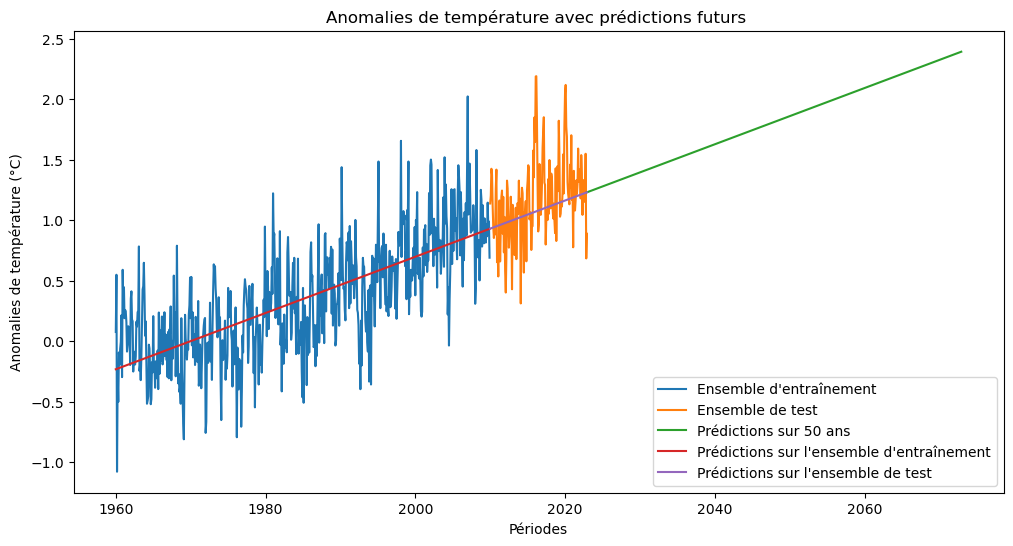

In [41]:
# Prédire les anomalies de température pour les 50 prochaines années

future_periods = future_periods.to_numpy().reshape(-1,1)
future_predictions = best_model.predict(future_periods)

# Créer un graphique des anomalies de température et des prédictions

plt.figure(figsize=(12, 6))
plt.plot(train_df["Périodes"], train_df["Anomalies de T.°"], label="Ensemble d'entraînement")
plt.plot(test_df["Périodes"], test_df["Anomalies de T.°"], label="Ensemble de test")
plt.plot(future_periods, future_predictions, label="Prédictions sur 50 ans")
plt.plot(train_df["Périodes"], y_train_pred, label="Prédictions sur l'ensemble d'entraînement")
plt.plot(test_df["Périodes"], y_test_pred, label="Prédictions sur l'ensemble de test")
plt.xlabel("Périodes")
plt.ylabel("Anomalies de température (°C)")
plt.legend()
plt.title("Anomalies de température avec prédictions futurs ")
plt.show();

Pour l'ensemble d'entraînement :

MAE (Mean Absolute Error) : 0.26096916098541445
MSE (Mean Squared Error) : 0.11189778207153495
RMSE (Root Mean Squared Error) : 0.33451125851237795
R² (Coefficient de détermination) : 0.5014505205687894

Pour l'ensemble de test :

MAE (Mean Absolute Error) : 0.2394088342016738
MSE (Mean Squared Error) : 0.10693830147168185
RMSE (Root Mean Squared Error) : 0.3270142221244847
R² (Coefficient de détermination) : 0.5014505205687894

La MAE représente l'erreur moyenne absolue entre les prédictions et les valeurs réelles. Dans les deux cas, la MAE est relativement faible, ce qui indique que le modèle est capable de prédire avec précision les anomalies de température pour les données d'entraînement et de test.

La MSE représente la moyenne des carrés des erreurs entre les prédictions et les valeurs réelles. La MSE est également relativement faible pour les deux ensembles de données, ce qui indique que les erreurs sont faibles.

Le RMSE est simplement la racine carrée de la MSE. Il mesure également l'erreur moyenne entre les prédictions et les valeurs réelles, mais donne plus de poids aux erreurs les plus importantes. Le RMSE est relativement faible dans les deux cas, ce qui suggère que le modèle est capable de prédire avec précision les anomalies de température.

Le coefficient de détermination (R²) mesure la proportion de la variance totale de la variable de réponse (anomalies de température) qui est expliquée par le modèle. Dans ce cas, le R² est de 0,5014 pour l'ensemble d'entraînement et de test. Cela indique que le modèle explique environ 50 % de la variance totale, ce qui n'est pas très élevé mais peut être considéré comme acceptable.

Dans l'ensemble, les métriques de performance suggèrent que le modèle de régression polynomiale est capable de prédire avec précision les anomalies de température pour les 50 prochaines années. Cependant, le faible coefficient de détermination suggère qu'il pourrait y avoir des facteurs non linéaires qui influencent les anomalies de température et qui ne sont pas pris en compte par le modèle. Il est donc important de prendre en compte ces résultats avec précaution et de continuer à améliorer le modèle en utilisant des approches plus sophistiquées.